In [1]:
import pickle
import matplotlib.pyplot as plt

# Load the dictionary from the file
path_to_read = '/Users/luisescobar/Documents/Thesis/DataSets/Dictionary'
file = 'completo1007_(edit).pkl'
name_to_read = f'{path_to_read}/{file}'

with open(name_to_read, 'rb') as file:
    loaded_dict = pickle.load(file)


In [2]:
loaded_dict.keys()

dict_keys(['df_801', 'df_802', 'df_803', 'df_806', 'df_807', 'df_808', 'df_809', 'df_810', 'df_811', 'df_812', 'df_813', 'df_814', 'df_815', 'df_816', 'df_817', 'df_818', 'df_819', 'df_820', 'df_821', 'df_822', 'df_823', 'df_824', 'df_825', 'df_826', 'df_827', 'df_828', 'df_829', 'df_830', 'df_831', 'df_832', 'df_833', 'df_834', 'df_835', 'df_836', 'df_839', 'df_840', 'df_841', 'df_842', 'df_843', 'df_844', 'df_845', 'df_846', 'df_849', 'df_850', 'df_851', 'df_853', 'df_854', 'df_855', 'df_856', 'df_857', 'df_858', 'df_859', 'df_860', 'df_861', 'df_862', 'df_863', 'df_868', 'df_869', 'df_870', 'df_871', 'df_872', 'df_873', 'df_874', 'df_875', 'df_876', 'df_877', 'df_878', 'df_879', 'df_880', 'df_881', 'df_882', 'df_883', 'df_884', 'df_885', 'df_886', 'df_887', 'df_888', 'df_889', 'df_891', 'df_892', 'df_893', 'df_894', 'df_895', 'df_896', 'df_897', 'df_898', 'df_899', 'df_900', 'df_901', 'df_902', 'df_903', 'df_904', 'df_905', 'df_906', 'df_907', 'df_908', 'df_909', 'df_910', 'df_914',

<div class="alert alert-block alert-warning">
  <p>
    <b>To Do</b>
  </p>

  <p>
    When using a time window instead of single steps, it could be a problem to handle two different types of filters, 
    since the reference values might be different. Consider this when running the code and base on the result we will
    implement a solution 
  </p>
    
  <p>
  </p>
</div>

In [3]:
def handle_case(case):
    '''The function returns the threshold value associated
    with the selected filter 
    Parameters
    ----------
    case : string 
        String with the name of the filter used in the current treatment

        
    Returns
    -------
    case : int
        Integer value associated to the threshold of the current
        filter
    '''
    
    cases = {
        'septeX':  450,
        'ST150':   450,
        'oXiris':  450,
        'TPE2000': 500,
        'X-MARS':  600,
        'M100':    450,
        'ST60':    450,
        'HF1000':  500,
        'ST100':   450,
        'HF1400':  500
    }
    return cases.get(case, "Case not found")

<div class="alert alert-block alert-warning">
  <p>
    <b>To Do</b>
  </p>

  <p>
    We need to validate that the timeseries is in order and that we don't have replicate velues, specially in merged DataFrames 
  </p>
    
  <p>
  </p>
</div>

<div class="alert alert-block alert-warning">
  <p>
    <b>To Do</b>
  </p>

  <p>
    <li>We need to write two functions, one for Delta P reference value and one for TMP reference value. </li>
  </p>
    <li>We need to write a function to save prescription's values and look for possible new values during the treatment</li>
  <p>
  </p>
</div>

In [4]:
def Delta_P_ref(index, df_test):
    reference = df_test['DeltaP'].iloc[index:index + 9].median()
    return reference

def TMP_ref(index, df_test):
    reference = df_test['TMP'].iloc[index:index + 9].median()
    return reference



Problem to address. 
The previous cell is working with all the Data Frame as a vector. With the new information, at each minute (each row) we need to check
1. if the prescription values have changed
2. in case prescription values have changed compute a new reference value
3. if prescription values are the same we need to evaluate the conditions of clotting
and it seems that we'll need a for loop to achieve this. However, can we achieve this without the use of a loop so we can speed up computations?

In [ ]:
# We need to see how to improve the performance of this function. Is slow for the task it needs to do

In [5]:
prescription_cols = ['Q_Blood_Pump', 'Q_Replacement', 'Q_Dialysate', 'Q_PBP', 'Q_Patient_Fluid_Removal'] 

for name, df_test in loaded_dict.items():
    df_test = df_test.reset_index(drop=True)
    index = 0
    # Since we want to calculate the reference values, we'll start to iterate on index 10
    start_index = index + 10
    #df_test = df_test.reset_index(drop=True)
    # We save the initial prescription values 
    Q_val_set = df_test.loc[index, prescription_cols]
    Delta_P_ref_loop = Delta_P_ref(index, df_test)
    TMP_ref_loop = TMP_ref(index, df_test)
    # Set the first 10 reference rows as False 
    df_test.loc[index:index+9, 'Condition_1'] = False
    df_test.loc[index:index+9, 'Condition_2'] = False
    df_length = len(df_test)
    
    while start_index < df_length:
        # We evaluate the current row prescription values
        Q_val_eval = df_test.loc[start_index, prescription_cols]
        #row = df_test.iloc[start_index]
        if Q_val_set.equals(Q_val_eval):
            pass
        # Prescription values changed therefore, we need to compute a new reference value (TMP and Delta P)
        else: 
            '''This else conditional works good if start_index is <= df_length - 10
            otherwise we need to change the values of start_index+9 and start_index += 10
            since will be out of range'''
            # We change the prescription values to the current row ones
            Q_val_set = Q_val_eval
            
            if start_index <= (df_length - 1 - 10):     
                # Calculate conditions for the next 10 rows
                condition_1 = df_test.loc[start_index:start_index+9, 'DeltaP'] > (Delta_P_ref_loop + 100)
                condition_2 = (df_test.loc[start_index:start_index+9, 'P_Filter'] >= 450) & (TMP_ref_loop > tmp_filter)
                                                                                                
                df_test.loc[start_index:start_index+9, 'Condition_1'] = condition_1
                df_test.loc[start_index:start_index+9, 'Condition_2'] = condition_2
                    
                # We compute a new Delta P ref value
                Delta_P_ref_loop = Delta_P_ref(start_index, df_test)
                # We compute a new TMP ref value
                TMP_ref_loop = TMP_ref(start_index, df_test)
                
                start_index += 10
            
            else:
                #This means that we are working on some index of the last 10 values of the time series
                end_index = df_length - 1 - start_index
                condition_1 = df_test.loc[start_index:start_index + end_index, 'DeltaP'] > (Delta_P_ref_loop + 100)
                condition_2 = (df_test.loc[start_index:start_index + end_index, 'P_Filter'] >= 450) & (TMP_ref_loop > tmp_filter)
                                                                                                
                df_test.loc[start_index:start_index + end_index, 'Condition_1'] = condition_1
                df_test.loc[start_index:start_index + end_index, 'Condition_2'] = condition_2

                start_index += end_index        
                
                
                

        # Save filter code
        tmp_filter = df_test.loc[start_index,'Set']
        tmp_filter = handle_case(tmp_filter)
        # Calculate conditions for the current row
        #condition_1 = df_test.loc[start_index, 'DeltaP'] > (Delta_P_ref_loop + 100)
        #condition_2 = ((df_test.loc[start_index, 'P_Filter'] >= 450) & (TMP_ref_loop > tmp_filter))

        # Update the DataFrame with the conditions
        df_test.at[start_index, 'Condition_1'] = df_test.loc[start_index, 'DeltaP'] > (Delta_P_ref_loop + 100)
        df_test.at[start_index, 'Condition_2'] = ((df_test.loc[start_index, 'P_Filter'] >= 450) & (TMP_ref_loop > tmp_filter))
        #print(start_index)
        start_index += 1
        

    
        
        
    
    # Using the conditions columns, obtained at each iteration, we can vectorize the clotting column (best performance)

    df_test['Clotting'] = df_test['Condition_1'] | df_test['Condition_2']
    loaded_dict[name] = df_test

    

        



# I want to add a label when clotting occurs
# Since I'm not sure about how to address the problem of labelling after clotting, what we'll do is
# to preserve the same logic and in the future if is necessary cut the information after the first clotting

# To improve
# It seems that the same filter is used duraing a single treatment. If this is the case, is redundant to obtain the 
# filter code at each iteration. Maybe this behaivor will be different for cases in which treatments were merged

'''We modify the index 
start_index += 9
so we don't consider the rows we'll use to compute the ref values. 
I don't consider a good idea to cut this information since is part of the time series evolution
however, comes to me the question of how to label this 10 rows (clotting/no clottting) used to compute the reference
We could keep using the previous reference values and after row 10 use the new ones. I could write a for loop to evaluate the 10
rows, after that keep going with the while loop'''

"We modify the index \nstart_index += 9\nso we don't consider the rows we'll use to compute the ref values. \nI don't consider a good idea to cut this information since is part of the time series evolution\nhowever, comes to me the question of how to label this 10 rows (clotting/no clottting) used to compute the reference\nWe could keep using the previous reference values and after row 10 use the new ones. I could write a for loop to evaluate the 10\nrows, after that keep going with the while loop"

In [9]:
start_index

274

In [6]:
df_test_bug = loaded_dict['df_801']
df_test_bug = df_test_bug.reset_index(drop=True)
df_test_bug.head()

,Date__Heure,P_Access,P_Filter,P_Effluent,P_Return,Q_Blood_Pump,Q_Replacement,Q_Dialysate,Q_PBP,Q_Patient_Fluid_Removal,DeltaP,TMP,TMPa,trt,Patient_weight__Kg_,Set,Condition_1,Condition_2,Clotting
0,2011-07-28 22:58:00,54,-25,-26,-38,120,1200,2000,1200,150,-12,-23.5,-29,801,170.0,ST150,False,False,False
1,2011-07-28 22:59:00,7,57,-13,33,120,1200,2000,1200,150,-1,40.0,40,801,170.0,ST150,False,False,False
2,2011-07-28 23:00:00,7,94,-1,60,120,1200,2000,1200,150,9,60.0,65,801,170.0,ST150,False,False,False
3,2011-07-28 23:01:00,27,121,28,95,120,1200,2000,1200,150,1,62.0,63,801,170.0,ST150,False,False,False
4,2011-07-28 23:02:00,6,112,19,72,120,1200,2000,1200,150,15,55.0,63,801,170.0,ST150,False,False,False


In [11]:
df_test_bug.tail()

,Date__Heure,P_Access,P_Filter,P_Effluent,P_Return,Q_Blood_Pump,Q_Replacement,Q_Dialysate,Q_PBP,Q_Patient_Fluid_Removal,DeltaP,TMP,TMPa,trt,Patient_weight__Kg_,Set
276,2013-11-02 23:02:00,-60,156,-35,79,150,1500,1000,1000,0,52,134.5,161,820,60.0,HF1000
277,2013-11-02 23:03:00,-63,149,-35,64,150,1500,1000,1000,0,60,123.5,154,820,60.0,HF1000
278,2013-11-02 23:04:00,-53,157,-41,73,150,1500,1000,1000,0,59,138.0,168,820,60.0,HF1000
279,2013-11-02 23:05:00,-52,164,-36,81,150,1500,1000,1000,0,58,140.5,170,820,60.0,HF1000
280,2013-11-02 23:06:00,-55,166,-34,77,150,1500,1000,1000,0,64,137.5,170,820,60.0,HF1000


In [ ]:
# This index will change depending on the prescription values
index = 0
for name, df_test in loaded_dict.items():
    #I need to update this reference value in case is necessary
    #Consider to do it at the end
    Delta_P_ref = Delta_P_ref(index)
    # Vectorized condition 1
    df_test['Condition_1'] = df_test['DeltaP'] > (reference + 100)

    # Vectorized condition 2
    tmp_filter = df_test['Set'].map(handle_case)
    TMP_ref = TMP_ref(index)
    df_test['Condition_2'] = (df_test['P_Filter'] >= 450) & (TMP_ref > tmp_filter)

    # Combined condition
    df_test['Clotting'] = df_test['Condition_1'] | df_test['Condition_2']
    
    if df_test['Clotting'].any():
        clotting_list.append([name, 'Clotting'])

In [16]:
clotting_list

[['df_802', 'Clotting'],
 ['df_810', 'Clotting'],
 ['df_814', 'Clotting'],
 ['df_819', 'Clotting'],
 ['df_825', 'Clotting'],
 ['df_831', 'Clotting'],
 ['df_841', 'Clotting'],
 ['df_856', 'Clotting'],
 ['df_858', 'Clotting'],
 ['df_859', 'Clotting'],
 ['df_862', 'Clotting'],
 ['df_870', 'Clotting'],
 ['df_873', 'Clotting'],
 ['df_877', 'Clotting'],
 ['df_881', 'Clotting'],
 ['df_885', 'Clotting'],
 ['df_886', 'Clotting'],
 ['df_889', 'Clotting'],
 ['df_892', 'Clotting'],
 ['df_893', 'Clotting'],
 ['df_897', 'Clotting'],
 ['df_898', 'Clotting'],
 ['df_900', 'Clotting'],
 ['df_902', 'Clotting'],
 ['df_905', 'Clotting'],
 ['df_909', 'Clotting'],
 ['df_915', 'Clotting'],
 ['df_919', 'Clotting'],
 ['df_920', 'Clotting'],
 ['df_921', 'Clotting'],
 ['df_923', 'Clotting'],
 ['df_932', 'Clotting'],
 ['df_944', 'Clotting'],
 ['df_946', 'Clotting'],
 ['df_950', 'Clotting'],
 ['df_955', 'Clotting'],
 ['df_959', 'Clotting'],
 ['df_964', 'Clotting'],
 ['df_969', 'Clotting'],
 ['df_978', 'Clotting'],


In [17]:
trt_number = 810
df_test = loaded_dict[f'df_{trt_number}']
df_reset = df_test.reset_index(drop=True)
df_reset.head(10)

,Date__Heure,P_Access,P_Filter,P_Effluent,P_Return,Q_Blood_Pump,Q_Replacement,Q_Dialysate,Q_PBP,DeltaP,TMP,TMPa,trt,Patient_weight__Kg_,Set,Condition_1,Condition_2,Clotting
0,2012-05-31 20:49:57,36,-21,-27,-38,130,1500,2000,1500,-8,-20.5,-24,810,150.0,HF1000,False,False,False
1,2012-05-31 20:50:00,36,-21,-27,-38,130,1500,2000,1500,-8,-20.5,-24,810,150.0,HF1000,False,False,False
2,2012-05-31 20:51:00,32,-21,-27,-38,130,1500,2000,1500,-8,-20.5,-24,810,150.0,HF1000,False,False,False
3,2012-05-31 20:52:00,46,-19,-25,-35,130,1500,2000,1500,-9,-20.0,-24,810,150.0,HF1000,False,False,False
4,2012-05-31 20:53:00,-11,37,5,6,130,1500,2000,1500,6,-1.5,2,810,150.0,HF1000,False,False,False
5,2012-05-31 20:54:00,-4,124,56,81,130,1500,2000,1500,18,28.5,38,810,150.0,HF1000,False,False,False
6,2012-05-31 20:55:00,-5,171,60,121,130,1500,2000,1500,25,68.0,81,810,150.0,HF1000,False,False,False
7,2012-05-31 20:56:00,-18,170,76,123,130,1500,2000,1500,22,52.5,64,810,150.0,HF1000,False,False,False
8,2012-05-31 20:57:00,-10,160,62,111,130,1500,2000,1500,24,55.5,68,810,150.0,HF1000,False,False,False
9,2012-05-31 20:58:00,-7,157,52,106,130,1500,2000,1500,26,61.5,75,810,150.0,HF1000,False,False,False


In [18]:
'''Find cases where Clotting is True'''
df_reset.index[df_test['Clotting'] == True].tolist()

[173, 174, 175, 176, 616, 668, 669]

In [19]:
#Search for specific intervals of clotting
df_reset.loc[32360:32390]

,Date__Heure,P_Access,P_Filter,P_Effluent,P_Return,Q_Blood_Pump,Q_Replacement,Q_Dialysate,Q_PBP,DeltaP,TMP,TMPa,trt,Patient_weight__Kg_,Set,Condition_1,Condition_2,Clotting


In [20]:
df_reset.tail(10)

,Date__Heure,P_Access,P_Filter,P_Effluent,P_Return,Q_Blood_Pump,Q_Replacement,Q_Dialysate,Q_PBP,DeltaP,TMP,TMPa,trt,Patient_weight__Kg_,Set,Condition_1,Condition_2,Clotting
862,2012-06-01 11:11:00,-10,167,-83,50,120,1000,1500,1000,92,173.5,220,810,150.0,HF1000,False,False,False
863,2012-06-01 11:12:00,-12,157,-79,47,120,1000,1500,1000,85,163.0,206,810,150.0,HF1000,False,False,False
864,2012-06-01 11:13:00,-10,165,-80,50,120,1000,1500,1000,90,169.5,215,810,150.0,HF1000,False,False,False
865,2012-06-01 11:14:00,-12,157,-78,42,120,1000,1500,1000,90,159.5,205,810,150.0,HF1000,False,False,False
866,2012-06-01 11:15:00,-4,169,-79,53,120,1000,1500,1000,91,172.0,218,810,150.0,HF1000,False,False,False
867,2012-06-01 11:16:00,-9,164,-83,47,120,1000,1500,1000,92,170.5,217,810,150.0,HF1000,False,False,False
868,2012-06-01 11:17:00,-5,168,-82,51,120,1000,1500,1000,92,173.5,220,810,150.0,HF1000,False,False,False
869,2012-06-01 11:18:00,-6,165,-77,48,120,1000,1500,1000,92,165.5,212,810,150.0,HF1000,False,False,False
870,2012-06-01 11:19:00,-4,168,-80,53,120,1000,1500,1000,90,172.5,218,810,150.0,HF1000,False,False,False
871,2012-06-01 11:20:00,-9,164,-83,47,120,1000,1500,1000,92,170.5,217,810,150.0,HF1000,False,False,False


In [21]:
'''
TO DO
In case we have the presence of clotting phenomenon we need to compute a new reference value for the new prescription parameters
'''

'\nTO DO\nIn case we have the presence of clotting phenomenon we need to compute a new reference value for the new prescription parameters\n'

In [22]:
#Problem to solve
'''
We want to plot several reference value in case we have new prescription indicators
'''

'\nWe want to plot several reference value in case we have new prescription indicators\n'

In [23]:
reference_value = df_reset['DeltaP'].iloc[index:index+9].median() + 100
reference_value

106.0

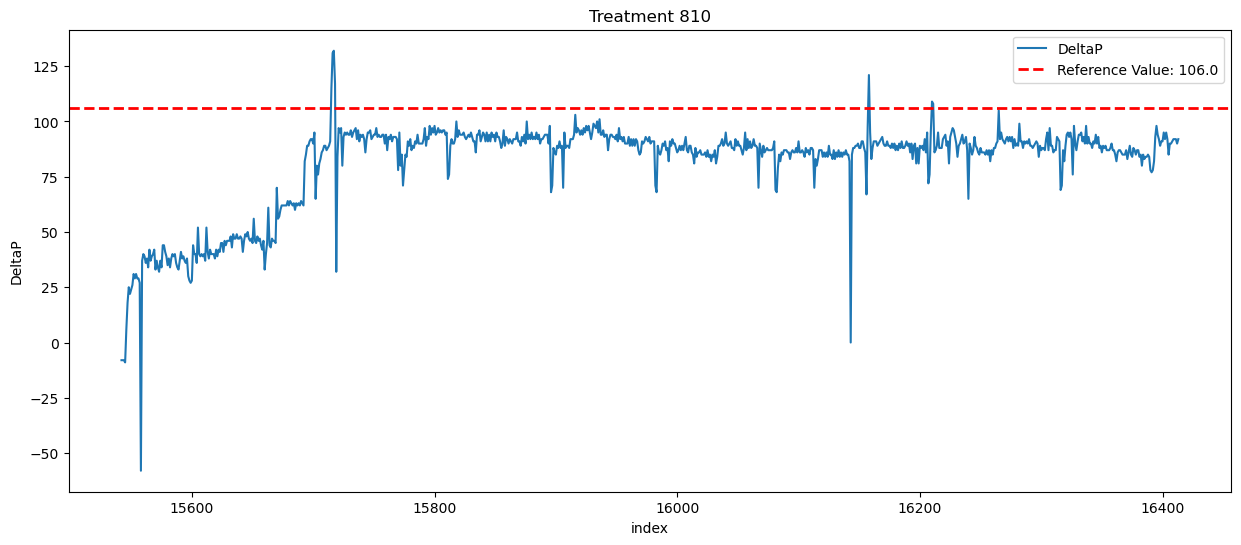

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))
df_test["DeltaP"].plot(xlabel="index", ylabel="DeltaP", title=f"Treatment {trt_number}", ax=ax);
ax.axhline(y=reference_value, color='red', linestyle='--', linewidth=2, label=f'Reference Value: {reference_value}')
ax.legend()
plt.show()